I found some better examples on how to do recurrent models with flax; let's try and recreate that

In [1]:
from reservoirtaming.layers.reservoirs import StructuredTransform, FastStructuredTransform
from reservoirtaming.models.generic import GenericEchoState
from reservoirtaming.layers.output import Residual
from reservoirtaming.training.training import ridge


from reservoirtaming.data.KS import KS
from jax import random
from functools import partial
import numpy as np

import jax.numpy as jnp
from jax.scipy.linalg import cho_factor, cho_solve
from flax.core import unfreeze, freeze
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

In [4]:
# Setting up model
n_reservoir = 3900
n_out = u_train.shape[-1]

norm_factor = 1.1 * jnp.sqrt(n_out / n_reservoir)
model = GenericEchoState(n_reservoir, FastStructuredTransform, (n_out, ),
                  n_out, Residual, (norm_factor, ))


key = random.PRNGKey(42)
state = model.initialize_state(key, n_reservoir)
params = model.init(key, state, u_train[0])

In [5]:
%%time
# Running the reservoir
new_state, intermediate_states = model.apply(params, state, u_train, method=model.run_reservoir)

CPU times: user 2.42 s, sys: 646 ms, total: 3.06 s
Wall time: 1.77 s


In [6]:
%%time
# Predicting with random output layer
n_predict_steps = 100
new_state, prediction = model.apply(params, state, u_train[0], n_predict_steps)

CPU times: user 1.34 s, sys: 846 ms, total: 2.18 s
Wall time: 838 ms


In [7]:
%%time
# Training; we simply update the output layer weight param 
end_of_train_state, params = ridge(model, params, state, u_train, renorm_factor=norm_factor, alpha=1e-2)

CPU times: user 3.55 s, sys: 337 ms, total: 3.89 s
Wall time: 3.94 s


In [8]:
%%time
# Extrapolate
n_predict_steps = 2000
end_of_predict_state, prediction = model.apply(params, end_of_train_state, u_train[-1], n_predict_steps)

CPU times: user 1.53 s, sys: 723 ms, total: 2.26 s
Wall time: 1.14 s


In [9]:
truth  = u_test.squeeze()
prediction = prediction.squeeze()

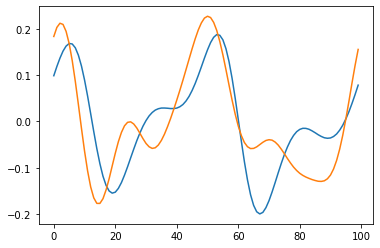

In [11]:
frame = 50
plt.plot(truth[frame])
plt.plot(prediction[frame])